In [2]:
import pandas as pd

df_orders = pd.read_csv('/olist_orders_dataset.csv')
df_items = pd.read_csv('/olist_order_items_dataset.csv')
df_customers = pd.read_csv('/olist_customers_dataset.csv')

print("Tudo carregado!")
print(f"Temos {df_orders.shape[0]} pedidos nas mãos.")
print(f"Temos {df_customers.shape[0]} clientes cadastrados.")

Tudo carregado!
Temos 99441 pedidos nas mãos.
Temos 99441 clientes cadastrados.


In [3]:
print("--- PEDIDOS (Orders) ---")
print(df_orders.head())

print("\n--- ITENS (Items) ---")
print(df_items.head())

--- PEDIDOS (Orders) ---
                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 1

In [4]:
# 1. Juntar Pedidos com Itens (usando order_id)
df_mestra = pd.merge(df_orders, df_items, on='order_id')

# 2. Juntar tudo isso com a tabela de Clientes (usando customer_id)
df_mestra = pd.merge(df_mestra, df_customers, on='customer_id')

# Ver o resultado final
print(f"Tabela Mestra criada com {df_mestra.shape[0]} linhas!")
print(df_mestra.head())

Tabela Mestra criada com 112650 linhas!
                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1       

In [5]:
# 1. Converter a data (que o Python leu como texto) para formato de Data Real
df_mestra['order_purchase_timestamp'] = pd.to_datetime(df_mestra['order_purchase_timestamp'])

# 2. Descobrir qual foi a data da última venda registrada no dataset (nosso "hoje")
data_maxima = df_mestra['order_purchase_timestamp'].max()

# 3. O Agrupamento Mágico (Calculando RFM)
rfm = df_mestra.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (data_maxima - x.max()).days, # Recência
    'order_id': 'count',                                                # Frequência
    'price': 'sum'                                                      # Monetário
})

# 4. Renomear as colunas para ficar fácil de ler
rfm.columns = ['Recencia', 'Frequencia', 'Monetario']

# Mostrar os primeiros 5 clientes
print(rfm.head())

                                  Recencia  Frequencia  Monetario
customer_unique_id                                               
0000366f3b9a7992bf8c76cfdf3221e2       115           1     129.90
0000b849f77a49e4a4ce2b2a4ca5be3f       118           1      18.90
0000f46a3911fa3c0805444483337064       541           1      69.00
0000f6ccb0745a6a4b88665a16c9f078       325           1      25.99
0004aac84e0df4da2b147fca70cf8255       292           1     180.00


In [6]:
from sklearn.preprocessing import StandardScaler

# 1. Instanciar o "Escalador"
scaler = StandardScaler()

# 2. Transformar os dados (Aprender a média e ajustar)
rfm_scaled = scaler.fit_transform(rfm)

# 3. Transformar de volta em Tabela (para conseguirmos ler)
rfm_scaled = pd.DataFrame(rfm_scaled, columns=rfm.columns, index=rfm.index)

# Ver como ficou (agora serão números estranhos, tipo -1.2 ou 0.5)
print(rfm_scaled.head())

                                  Recencia  Frequencia  Monetario
customer_unique_id                                               
0000366f3b9a7992bf8c76cfdf3221e2 -0.833121   -0.290564  -0.057615
0000b849f77a49e4a4ce2b2a4ca5be3f -0.813533   -0.290564  -0.567596
0000f46a3911fa3c0805444483337064  1.948293   -0.290564  -0.337415
0000f6ccb0745a6a4b88665a16c9f078  0.537999   -0.290564  -0.535021
0004aac84e0df4da2b147fca70cf8255  0.322537   -0.290564   0.172566


Calculando o melhor número de grupos... (pode demorar um pouco)


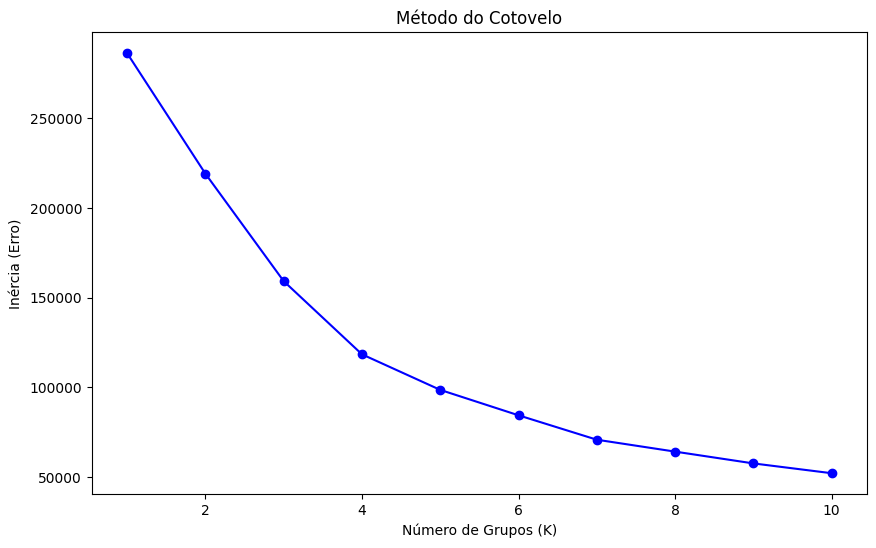

In [7]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Lista para guardar o "erro" de cada tentativa
inercia = []

# Vamos testar dividir os clientes em 1 grupo, depois 2, até 10
k_range = range(1, 11)

print("Calculando o melhor número de grupos... (pode demorar um pouco)")

for k in k_range:
    # 1. Criar o modelo com 'k' grupos
    km = KMeans(n_clusters=k, random_state=42, n_init=10)

    # 2. Treinar com os dados escalados
    km.fit(rfm_scaled)

    # 3. Guardar o nível de erro (Inertia)
    inercia.append(km.inertia_)

# Desenhar o gráfico
plt.figure(figsize=(10,6))
plt.plot(k_range, inercia, 'bo-') # 'bo-' faz bolinhas azuis conectadas
plt.title('Método do Cotovelo')
plt.xlabel('Número de Grupos (K)')
plt.ylabel('Inércia (Erro)')
plt.show()

In [8]:
# 1. Rodar o K-Means definitivo com 4 grupos
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(rfm_scaled)

# 2. Pegar os rótulos (0, 1, 2, 3) e colocar na tabela original
rfm['Grupo'] = kmeans.labels_

# 3. Calcular a média de cada grupo para entendermos quem é quem
analise_grupos = rfm.groupby('Grupo').mean()

print(analise_grupos)


         Recencia  Frequencia    Monetario
Grupo                                     
0      392.599442    1.095729   114.335776
1      132.526714    1.097471   113.904079
2      235.571225    3.871795   280.351620
3      241.961412    1.194353  1167.534047


/tmp/ipython-input-2229009504.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Segmento', data=rfm, palette='viridis', order=['VIP 💎', 'Leal 🔄', 'Novo / Comum 👤', 'Perdido (Churn) 💤'])
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128142 (\N{GEM STONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128100 (\N{BUST IN SILHOUETTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-

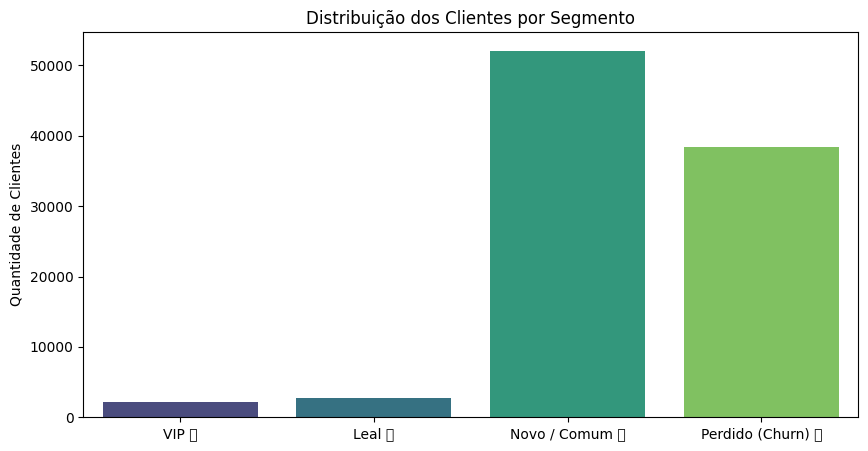

Segmento
Novo / Comum 👤       52108
Perdido (Churn) 💤    38379
Leal 🔄                2808
VIP 💎                 2125
Name: count, dtype: int64


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Função para definir os nomes baseados nas médias
def definir_nome_grupo(cluster_id, tabela_medias):
    # Pega os valores médios desse grupo
    grupo = tabela_medias.loc[cluster_id]

    # Regras de Negócio (Lógica do Marketing)
    if grupo['Monetario'] == tabela_medias['Monetario'].max():
        return 'VIP 💎'
    elif grupo['Recencia'] == tabela_medias['Recencia'].max():
        return 'Perdido (Churn) 💤'
    elif grupo['Frequencia'] == tabela_medias['Frequencia'].max() and grupo['Recencia'] < tabela_medias['Recencia'].mean():
        return 'Leal 🔄' # Compra sempre e comprou recentemente
    else:
        return 'Novo / Comum 👤' # O resto

# 2. Aplicar a função
nomes_grupos = {k: definir_nome_grupo(k, analise_grupos) for k in analise_grupos.index}
rfm['Segmento'] = rfm['Grupo'].map(nomes_grupos)

# 3. Visualizar a Quantidade de Clientes por Grupo
plt.figure(figsize=(10, 5))
sns.countplot(x='Segmento', data=rfm, palette='viridis', order=['VIP 💎', 'Leal 🔄', 'Novo / Comum 👤', 'Perdido (Churn) 💤'])
plt.title('Distribuição dos Clientes por Segmento')
plt.xlabel('')
plt.ylabel('Quantidade de Clientes')
plt.show()

# Ver quem ficou em cada lugar
print(rfm['Segmento'].value_counts())